# Random Forest

In [1]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

In [2]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Define evaluation metrics
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Primary Type
rf_primary = RandomForestClassifier(random_state=42)
rf_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = rf_primary.predict(X_test_scaled)
print("Random Forest - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
rf_both = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = rf_both.predict(X_test_scaled)
y_pred_both_probas = np.array([estimator.predict_proba(X_test_scaled)[:, 1] 
                              for estimator in rf_both.estimators_]).T

# Ensure at least one type prediction
threshold = 0.5
y_pred_both = (y_pred_both_probas >= threshold).astype(int)
for i in range(len(y_pred_both)):
    if not np.any(y_pred_both[i]):
        max_prob_idx = np.argmax(y_pred_both_probas[i])
        y_pred_both[i, max_prob_idx] = 1

# Calculate metrics for Both Types
print("\nRandom Forest - Both Types Metrics:")
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')
hamming_loss_value = hamming_loss(y_test_both_bin, y_pred_both)
precision_at_2 = precision_at_k(y_test_both_bin, y_pred_both_probas, k=2)
recall_at_2 = recall_at_k(y_test_both_bin, y_pred_both_probas, k=2)

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")
print(f"Hamming Loss: {hamming_loss_value:.3f}")
print(f"Precision@2: {precision_at_2:.3f}")
print(f"Recall@2: {recall_at_2:.3f}")

# Generation
rf_generation = RandomForestClassifier(random_state=42)
rf_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = rf_generation.predict(X_test_scaled)
print("\nRandom Forest - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Random Forest - Primary Type Accuracy: 0.22439024390243903

Random Forest - Both Types Metrics:
Exact Match Ratio: 0.112
Jaccard Score: 0.193
F1 Score: 0.220
Hamming Loss: 0.107
Precision@2: 0.241
Recall@2: 0.344

Random Forest - Generation Accuracy: 0.1902439024390244


In [2]:
# Model Implementation
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Primary Type Prediction
rf_primary = RandomForestClassifier(random_state=42)

# Both Types Prediction
rf_both = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# Generation Prediction
rf_generation = RandomForestClassifier(random_state=42)

In [3]:
# Results 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, hamming_loss, accuracy_score, f1_score, jaccard_score

# Primary Type Prediction
print("Primary Type Prediction:")

# Before tuning
scores_primary_before = cross_val_score(rf_primary, X_train_scaled, y_train_primary, cv=5)
print(f"Before tuning - Mean CV score: {scores_primary_before.mean():.3f} (+/- {scores_primary_before.std() * 2:.3f})")

# After tuning
param_grid_primary = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_primary = GridSearchCV(rf_primary, param_grid_primary, cv=5)
grid_search_primary.fit(X_train_scaled, y_train_primary)

print("Best parameters:", grid_search_primary.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_primary.best_score_:.3f}")

# Evaluate on test set
y_pred_primary = grid_search_primary.predict(X_test_scaled)
test_accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print(f"Test set accuracy: {test_accuracy_primary:.3f}")

Primary Type Prediction:
Before tuning - Mean CV score: 0.239 (+/- 0.043)
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
After tuning - Best cross-validation score: 0.257
Test set accuracy: 0.224


In [ ]:
### Takes around 3 minutes to run currently
# Both Types Prediction
print("\nBoth Types Prediction:")

# Before tuning
scores_both_before = cross_val_score(rf_both, X_train_scaled, y_train_both_bin, cv=5, 
                                     scoring=make_scorer(hamming_loss, greater_is_better=False))
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# After tuning
param_grid_both = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}
grid_search_both = GridSearchCV(rf_both, param_grid_both, cv=5, scoring=make_scorer(hamming_loss, greater_is_better=False))
grid_search_both.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

# Evaluate on test set
y_pred_both = grid_search_both.predict(X_test_scaled)
test_hamming_loss = hamming_loss(y_test_both_bin, y_pred_both)
print(f"Test set Hamming Loss: {test_hamming_loss:.3f}")

# Calculate exact match ratio
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.3f}")

# Additional metrics
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")

f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')
print(f"F1 Score: {f1_score_value:.3f}")


Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.086 (+/- 0.003)
Best parameters: {'estimator__max_depth': 10, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
After tuning - Best cross-validation Hamming Loss: 0.085
Test set Hamming Loss: 0.081
Exact Match Ratio: 0.015
Jaccard Similarity Score: 0.024
F1 Score: 0.028


In [5]:
# Generation Prediction
print("\nGeneration Prediction:")

# Before tuning
scores_gen_before = cross_val_score(rf_generation, X_train_scaled, y_train_generation, cv=5)
print(f"Before tuning - Mean CV score: {scores_gen_before.mean():.3f} (+/- {scores_gen_before.std() * 2:.3f})")

# After tuning
param_grid_gen = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_gen = GridSearchCV(rf_generation, param_grid_gen, cv=5)
grid_search_gen.fit(X_train_scaled, y_train_generation)

print("Best parameters:", grid_search_gen.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_gen.best_score_:.3f}")

# Evaluate on test set
y_pred_gen = grid_search_gen.predict(X_test_scaled)
test_accuracy_gen = accuracy_score(y_test_generation, y_pred_gen)
print(f"Test set accuracy: {test_accuracy_gen:.3f}")


Generation Prediction:
Before tuning - Mean CV score: 0.173 (+/- 0.032)
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
After tuning - Best cross-validation score: 0.196
Test set accuracy: 0.224


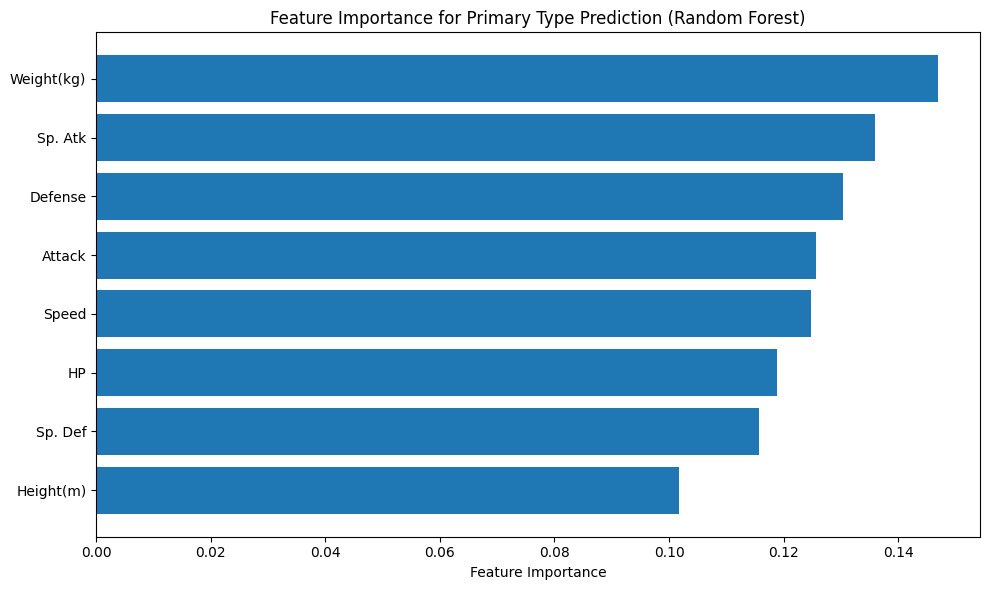

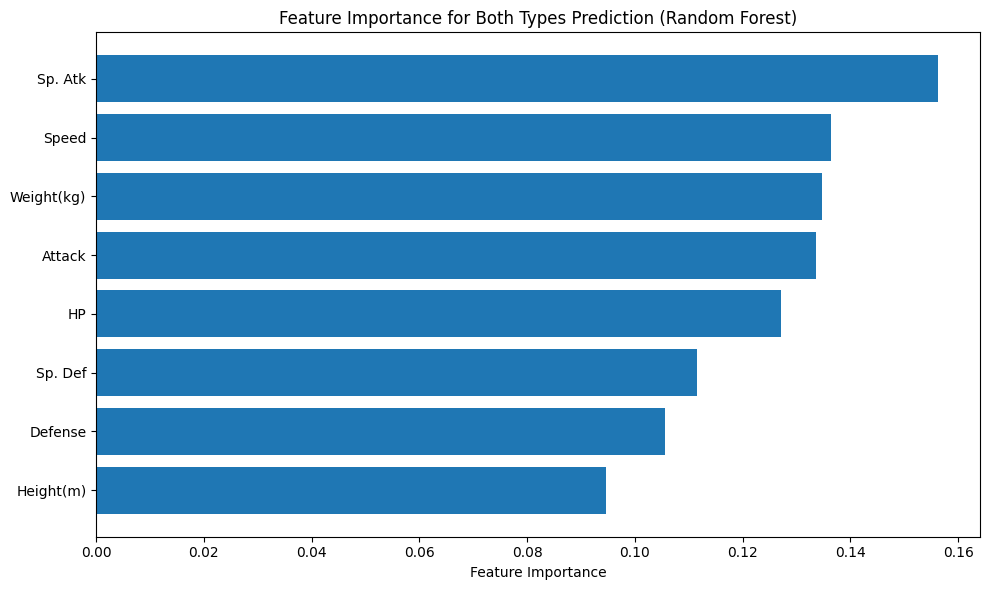

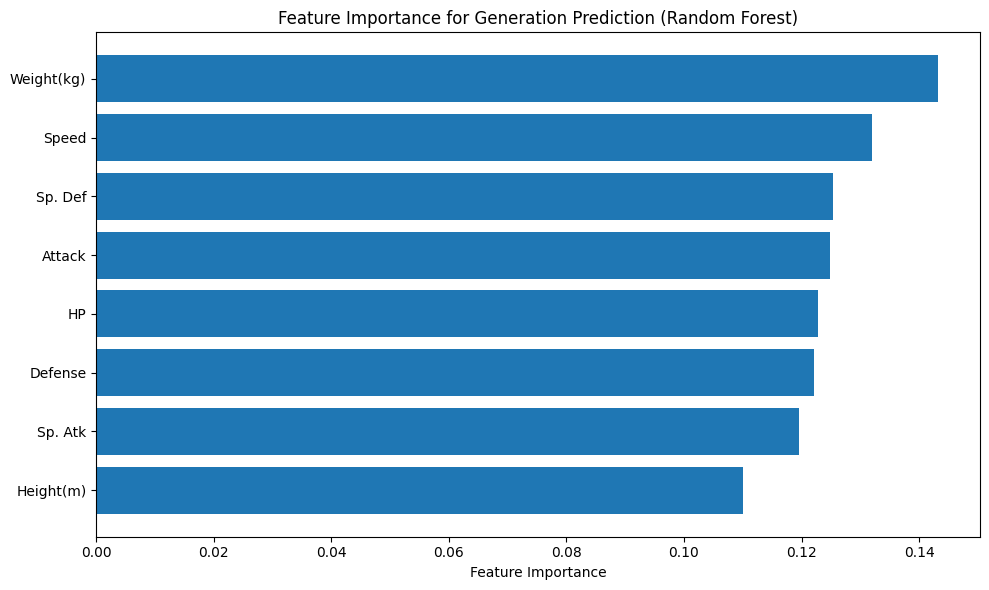

In [6]:
# Feature Importance
import matplotlib.pyplot as plt

def plot_feature_importance(importance, title):
    sorted_idx = importance.argsort()
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10, 6))
    plt.barh(pos, importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Primary Type Feature Importance
primary_importance = grid_search_primary.best_estimator_.feature_importances_
plot_feature_importance(primary_importance, 'Feature Importance for Primary Type Prediction (Random Forest)')

# Both Types Feature Importance
both_importance = grid_search_both.best_estimator_.estimators_[0].feature_importances_
plot_feature_importance(both_importance, 'Feature Importance for Both Types Prediction (Random Forest)')

# Generation Feature Importance
gen_importance = grid_search_gen.best_estimator_.feature_importances_
plot_feature_importance(gen_importance, 'Feature Importance for Generation Prediction (Random Forest)')

## All features

In [9]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('engineered_csv/train_combined_features.csv')
test_df = pd.read_csv('engineered_csv/test_combined_features.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'RGB_Min', 
                  'LBP_Mean', 'LBP_Std', 'LBP_Max', 'LBP_Min',
                  'CNN_Mean', 'CNN_Std', 'CNN_Max', 'CNN_Min']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

all_features = original_features + engineered_features + image_features

# Check if all features are present in the dataframes
missing_features = [f for f in all_features if f not in train_df.columns or f not in test_df.columns]
if missing_features:
    print("Warning: The following features are missing:", missing_features)
    all_features = [f for f in all_features if f not in missing_features]

X_train = train_df[all_features]
X_test = test_df[all_features]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("\nX_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

Train dataset shape: (820, 47)
Test dataset shape: (205, 47)
X_train shape: (820, 39)
X_test shape: (205, 39)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 39)
X_test_scaled shape: (205, 39)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 

In [3]:
# Baseline without CV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Primary Type
rf_primary = RandomForestClassifier(random_state=42)
rf_primary.fit(X_train_final, y_train_primary)
y_pred_primary = rf_primary.predict(X_test_final)
print("Random Forest - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
rf_both = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_both.fit(X_train_final, y_train_both_bin)
y_pred_both = rf_both.predict(X_test_final)
y_pred_both_probas = rf_both.predict_proba(X_test_final)

print("Random Forest - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics for Both Types
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Generation
rf_generation = RandomForestClassifier(random_state=42)
rf_generation.fit(X_train_final, y_train_generation)
y_pred_generation = rf_generation.predict(X_test_final)
print("Random Forest - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Random Forest - Primary Type Accuracy: 0.2146341463414634
Random Forest - Both Types Hamming Loss: 0.08644986449864499
Exact Match Ratio: 0.010
Jaccard Similarity Score: 0.012
F1 Score: 0.013
Random Forest - Generation Accuracy: 0.33658536585365856


## Final Improved Model 

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# Define evaluation metrics
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Calculate class weights
primary_weights = compute_class_weight('balanced', classes=np.unique(y_train_primary), y=y_train_primary)
primary_weight_dict = dict(zip(np.unique(y_train_primary), primary_weights))

generation_weights = compute_class_weight('balanced', classes=np.unique(y_train_generation), y=y_train_generation)
generation_weight_dict = dict(zip(np.unique(y_train_generation), generation_weights))

# Define parameter grids
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Primary Type
rf_primary = RandomForestClassifier(random_state=42)
# Feature selection using model's feature importance
selector = SelectFromModel(rf_primary, prefit=False)
grid_search_primary = GridSearchCV(
    rf_primary, param_grid, cv=5,
    scoring='accuracy', n_jobs=-1
)
grid_search_primary.fit(X_train_final, y_train_primary)
y_pred_primary = grid_search_primary.predict(X_test_final)

# Both Types - Train separate models for each type
rf_models = []
y_pred_both_probas = []
for i in range(y_train_both_bin.shape[1]):
    rf = RandomForestClassifier(
        **grid_search_primary.best_params_,
        random_state=42
    )
    rf.fit(X_train_final, y_train_both_bin[:, i])
    rf_models.append(rf)
    y_pred_both_probas.append(rf.predict_proba(X_test_final)[:, 1])

# Get predictions and probabilities
y_pred_both_probas = np.column_stack(y_pred_both_probas)
threshold = 0.5
y_pred_both = (y_pred_both_probas >= threshold).astype(int)

# Ensure at least one type prediction
for i in range(len(y_pred_both)):
    if not np.any(y_pred_both[i]):
        max_prob_idx = np.argmax(y_pred_both_probas[i])
        y_pred_both[i, max_prob_idx] = 1

# Generation
grid_search_generation = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid, cv=5,
    scoring='accuracy', n_jobs=-1
)
grid_search_generation.fit(X_train_final, y_train_generation)
y_pred_generation = grid_search_generation.predict(X_test_final)

# Print results and metrics
print("Random Forest Results:")
print("\nPrimary Type:")
print(f"Best parameters: {grid_search_primary.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_primary, y_pred_primary):.3f}")

print("\nBoth Types Metrics:")
print(f"Exact Match Ratio: {np.mean(np.all(y_pred_both == y_test_both_bin, axis=1)):.3f}")
print(f"Jaccard Score: {jaccard_score(y_test_both_bin, y_pred_both, average='samples'):.3f}")
print(f"F1 Score: {f1_score(y_test_both_bin, y_pred_both, average='samples'):.3f}")
print(f"Hamming Loss: {hamming_loss(y_test_both_bin, y_pred_both):.3f}")
print(f"Precision@2: {precision_at_k(y_test_both_bin, y_pred_both_probas, k=2):.3f}")
print(f"Recall@2: {recall_at_k(y_test_both_bin, y_pred_both_probas, k=2):.3f}")

print("\nGeneration:")
print(f"Best parameters: {grid_search_generation.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_generation, y_pred_generation):.3f}")

Random Forest Results:

Primary Type:
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.166

Both Types Metrics:
Exact Match Ratio: 0.141
Jaccard Score: 0.207
F1 Score: 0.229
Hamming Loss: 0.107
Precision@2: 0.224
Recall@2: 0.332

Generation:
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.302


In [17]:
# Comprehensive Output of Model
import numpy as np
import pandas as pd

# Function to create DataFrame for misclassified and correctly classified cases
def create_classification_df(test_names, actual_labels, predicted_labels, label_type):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Misclassified DataFrame
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })

    # Correctly classified DataFrame
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    return misclassified_df, correct_df

# Primary Type Classification
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary"
)

# Both Types Classification
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation Classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    y_pred_generation,
    "Generation"
)

# Print results
print("Misclassified Primary Types:")
print(misclassified_primary_df.head())
print(f"Total misclassifications: {len(misclassified_primary_df)}")
print(f"Misclassification rate: {len(misclassified_primary_df) / len(y_test_primary):.2%}\n")

print("Correctly Classified Primary Types:")
print(correct_primary_df.head())
print(f"Total correct classifications: {len(correct_primary_df)}")
print(f"Correct classification rate: {len(correct_primary_df) / len(y_test_primary):.2%}\n")

print("Misclassified Both Types:")
print(misclassified_both_df.head())
print(f"Total misclassifications: {len(misclassified_both_df)}")
print(f"Misclassification rate: {len(misclassified_both_df) / len(y_test_both_bin):.2%}\n")

print("Correctly Classified Both Types:")
print(correct_both_df.head())
print(f"Total correct classifications: {len(correct_both_df)}")
print(f"Correct classification rate: {len(correct_both_df) / len(y_test_both_bin):.2%}\n")

print("Misclassified Generations:")
print(misclassified_generation_df.head())
print(f"Total misclassifications: {len(misclassified_generation_df)}")
print(f"Misclassification rate: {len(misclassified_generation_df) / len(y_test_generation):.2%}\n")

print("Correctly Classified Generations:")
print(correct_generation_df.head())
print(f"Total correct classifications: {len(correct_generation_df)}")
print(f"Correct classification rate: {len(correct_generation_df) / len(y_test_generation):.2%}\n")

Misclassified Primary Types:
         Name Actual Primary Predicted Primary
0    Hakamo-o         Dragon            Normal
1       Absol           Dark            Normal
2    Meloetta         Normal           Psychic
3    Meganium          Grass             Fairy
5  Conkeldurr       Fighting            Normal
Total misclassifications: 171
Misclassification rate: 83.41%

Correctly Classified Primary Types:
          Name Actual Primary Predicted Primary
4      Nincada            Bug               Bug
9    Poliwrath          Water             Water
18  Bouffalant         Normal            Normal
19      Bidoof         Normal            Normal
21      Feebas          Water             Water
Total correct classifications: 34
Correct classification rate: 16.59%

Misclassified Both Types:
       Name      Actual Types Predicted Types
0  Hakamo-o  Dragon, Fighting           Water
1     Absol              Dark          Normal
2  Meloetta   Normal, Psychic         Psychic
3  Meganium           

## Visualizations
confusion matrices

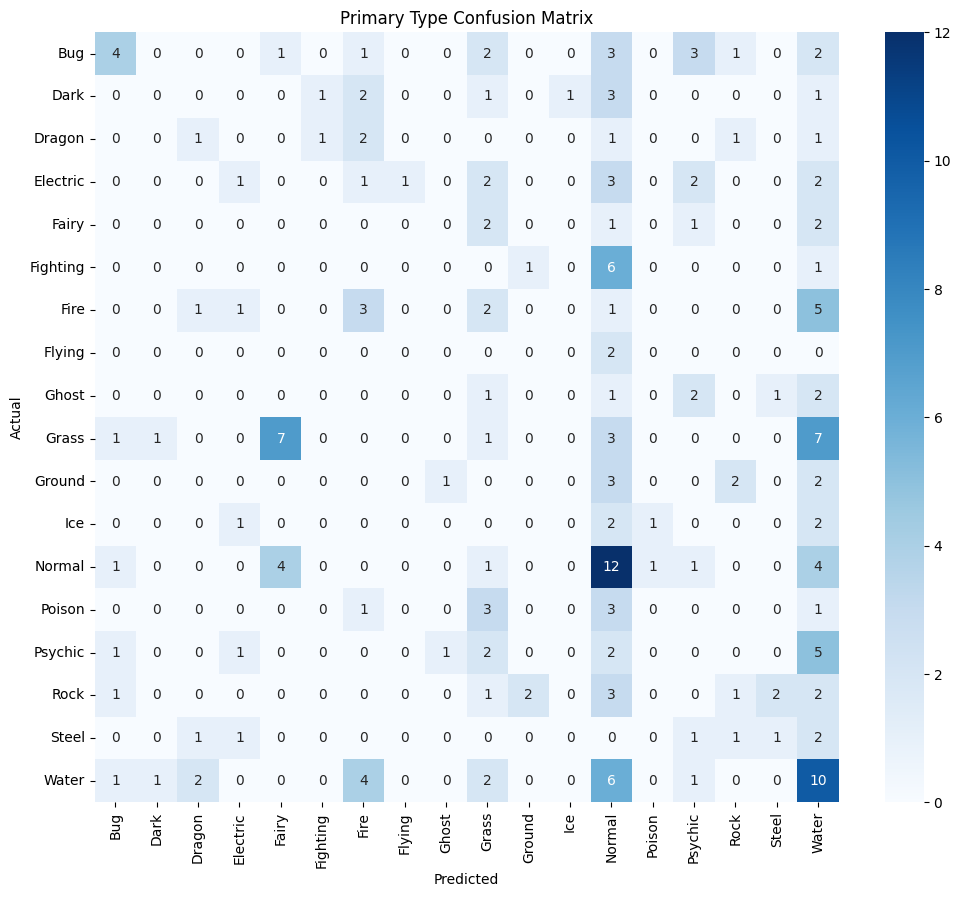

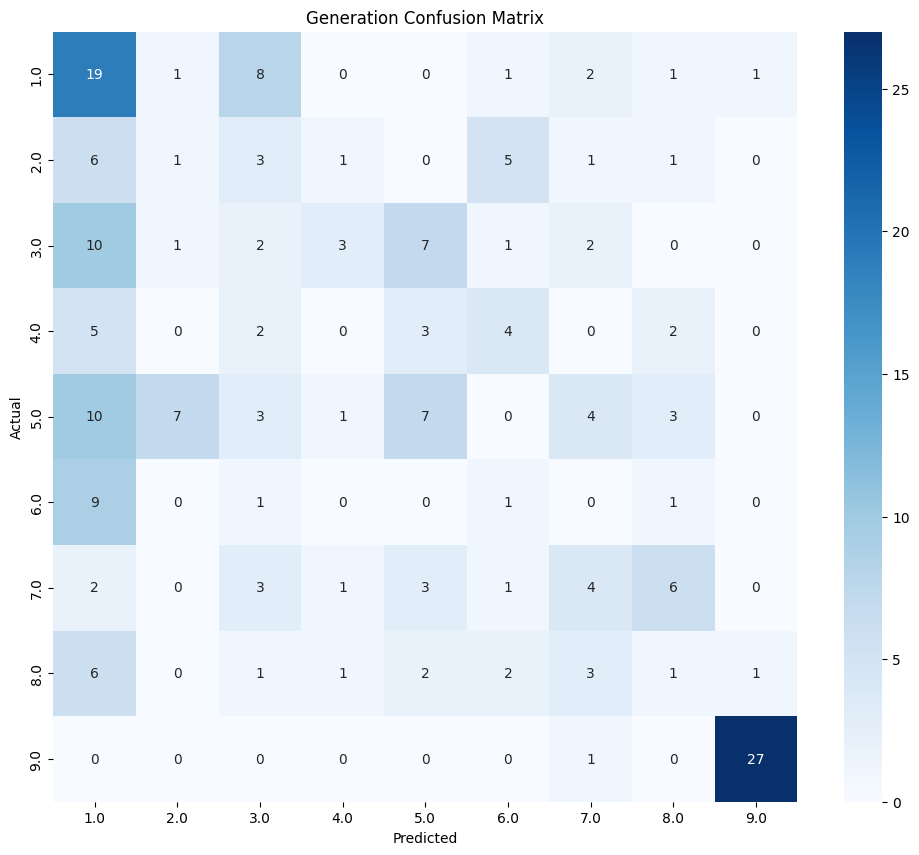

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Primary Type
plot_confusion_matrix(y_test_primary, y_pred_primary, np.unique(y_train_primary), 'Primary Type Confusion Matrix')

# Generation
plot_confusion_matrix(y_test_generation, y_pred_generation, np.unique(y_train_generation), 'Generation Confusion Matrix')

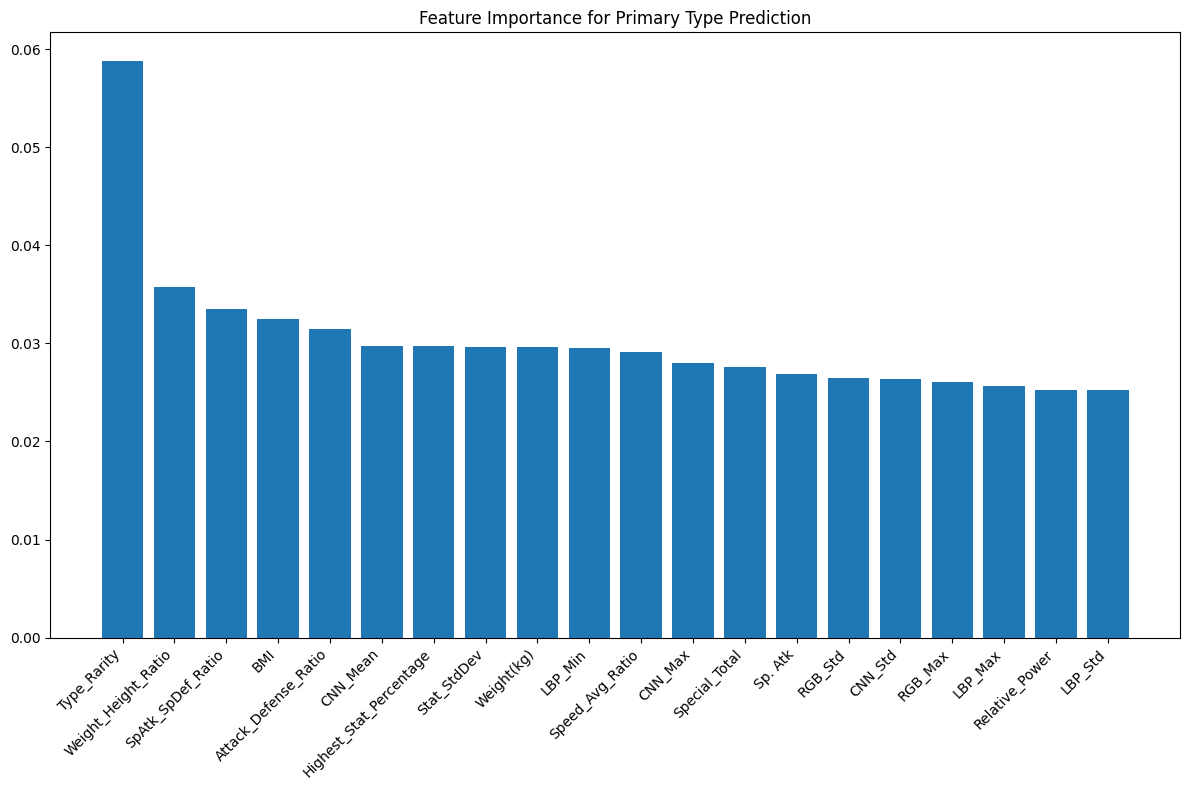

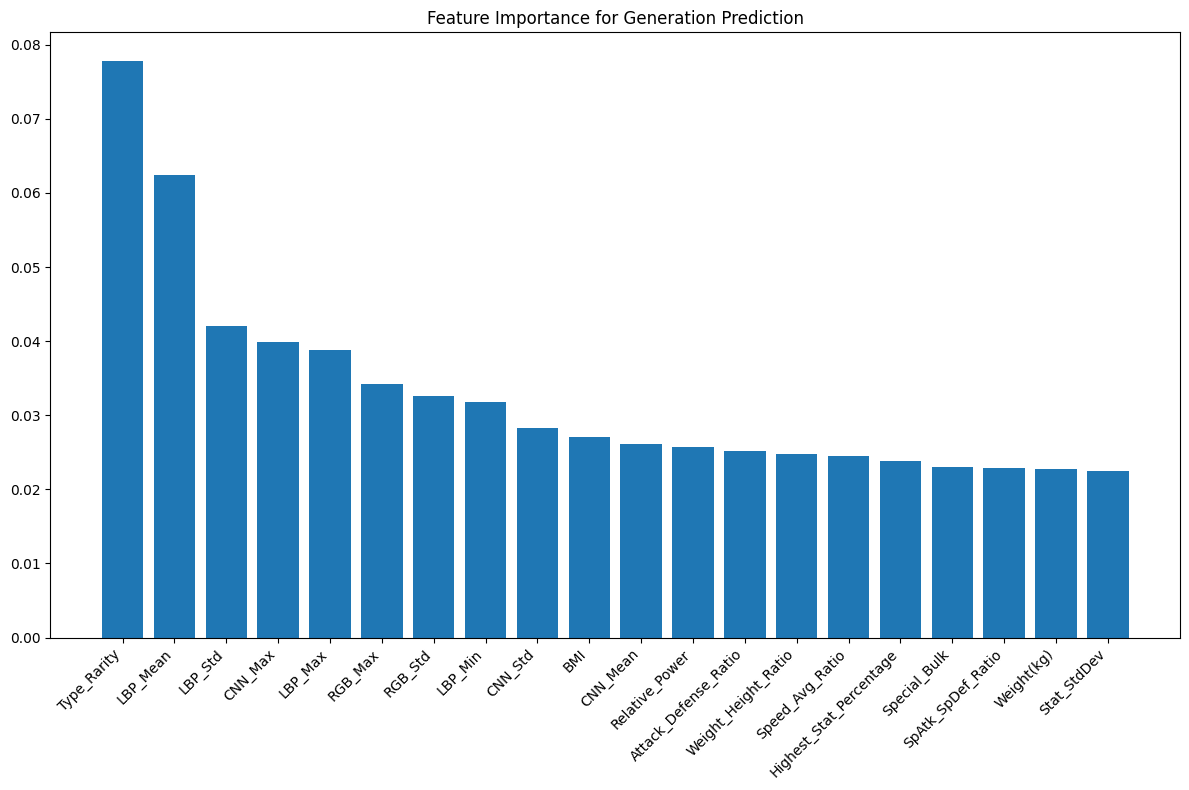


Top 10 Features for Primary Type Prediction:
                    feature  importance
26              Type_Rarity    0.058807
24      Weight_Height_Ratio    0.035737
9         SpAtk_SpDef_Ratio    0.033523
23                      BMI    0.032498
8      Attack_Defense_Ratio    0.031468
35                 CNN_Mean    0.029713
17  Highest_Stat_Percentage    0.029708
15              Stat_StdDev    0.029679
7                Weight(kg)    0.029620
34                  LBP_Min    0.029514

Top 10 Features for Generation Prediction:
        feature  importance
26  Type_Rarity    0.077783
31     LBP_Mean    0.062418
32      LBP_Std    0.042040
37      CNN_Max    0.039938
33      LBP_Max    0.038737
29      RGB_Max    0.034170
28      RGB_Std    0.032544
34      LBP_Min    0.031779
36      CNN_Std    0.028321
23          BMI    0.026997


In [15]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(model, feature_names, title, top_n=20):
    # Get feature importance
    importances = model.feature_importances_
    
    # Create DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    # Plot top N features
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), feature_importance_df['importance'][:top_n])
    plt.xticks(range(top_n), feature_importance_df['feature'][:top_n], rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Create feature names list
feature_names = (original_features + engineered_features + image_features + 
                list(X_train_cat.columns))

# Train Random Forest models
rf_primary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_primary.fit(X_train_final, y_train_primary)

rf_generation = RandomForestClassifier(n_estimators=100, random_state=42)
rf_generation.fit(X_train_final, y_train_generation)

# Plot feature importance for primary type prediction
primary_importance = plot_feature_importance(rf_primary, feature_names, 
                                          'Feature Importance for Primary Type Prediction')

# Plot feature importance for generation prediction
generation_importance = plot_feature_importance(rf_generation, feature_names,
                                             'Feature Importance for Generation Prediction')

# Print top 10 features for each task
print("\nTop 10 Features for Primary Type Prediction:")
print(primary_importance.head(10))

print("\nTop 10 Features for Generation Prediction:")
print(generation_importance.head(10))

In [13]:
def analyze_misclassifications(y_true, y_pred, labels):
    misclassified = y_true != y_pred
    misclassification_counts = pd.DataFrame({
        'Actual': y_true[misclassified],
        'Predicted': y_pred[misclassified]
    }).groupby(['Actual', 'Predicted']).size().sort_values(ascending=False)
    print("Top 10 Misclassifications:")
    print(misclassification_counts.head(10))

print("Primary Type Misclassifications:")
analyze_misclassifications(y_test_primary, y_pred_primary, np.unique(y_train_primary))

print("\nGeneration Misclassifications:")
analyze_misclassifications(y_test_generation, y_pred_generation, np.unique(y_train_generation))

Primary Type Misclassifications:
Top 10 Misclassifications:
Actual    Predicted
Grass     Fairy        7
          Water        7
Water     Normal       6
Fighting  Normal       6
Fire      Water        5
Psychic   Water        5
Water     Fire         4
Normal    Fairy        4
          Water        4
Bug       Psychic      3
dtype: int64

Generation Misclassifications:
Top 10 Misclassifications:
Actual  Predicted
5.0     1.0          10
3.0     1.0          10
6.0     1.0           9
1.0     3.0           8
5.0     2.0           7
3.0     5.0           7
8.0     1.0           6
7.0     8.0           6
2.0     1.0           6
4.0     1.0           5
dtype: int64


In [14]:
def analyze_both_types(y_true, y_pred, mlb):
    correct_count = np.sum(np.all(y_true == y_pred, axis=1))
    partial_correct_count = np.sum(np.any(y_true == y_pred, axis=1)) - correct_count
    incorrect_count = len(y_true) - correct_count - partial_correct_count

    print(f"Completely Correct: {correct_count} ({correct_count/len(y_true):.2%})")
    print(f"Partially Correct: {partial_correct_count} ({partial_correct_count/len(y_true):.2%})")
    print(f"Completely Incorrect: {incorrect_count} ({incorrect_count/len(y_true):.2%})")

    type_accuracy = np.mean(y_true == y_pred, axis=0)
    type_names = mlb.classes_
    type_performance = pd.DataFrame({'Type': type_names, 'Accuracy': type_accuracy})
    print("\nType-wise Accuracy:")
    print(type_performance.sort_values('Accuracy', ascending=False))

print("Both Types Analysis:")
analyze_both_types(y_test_both_bin, y_pred_both, mlb)

Both Types Analysis:
Completely Correct: 29 (14.15%)
Partially Correct: 176 (85.85%)
Completely Incorrect: 0 (0.00%)

Type-wise Accuracy:
        Type  Accuracy
11       Ice  0.960976
8      Ghost  0.941463
15      Rock  0.936585
1       Dark  0.936585
4      Fairy  0.931707
2     Dragon  0.926829
16     Steel  0.926829
0        Bug  0.917073
3   Electric  0.917073
13    Poison  0.917073
10    Ground  0.912195
5   Fighting  0.907317
6       Fire  0.907317
7     Flying  0.887805
14   Psychic  0.868293
9      Grass  0.824390
17     Water  0.736585
12    Normal  0.726829


Misclassified Primary Types:


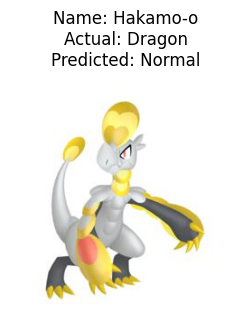

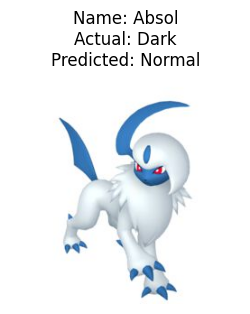

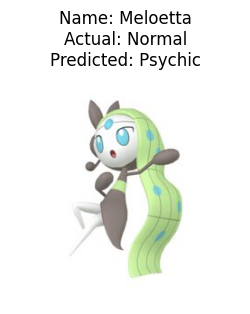

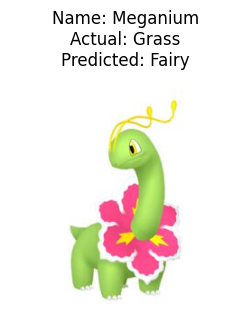

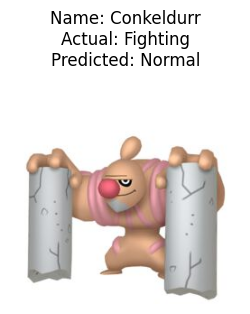

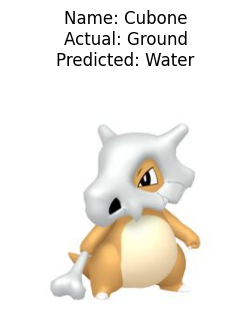

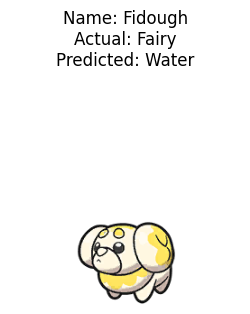

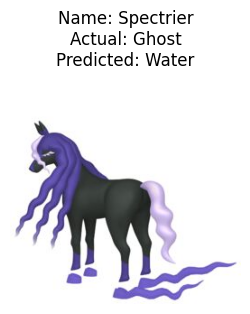

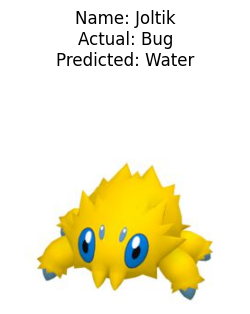

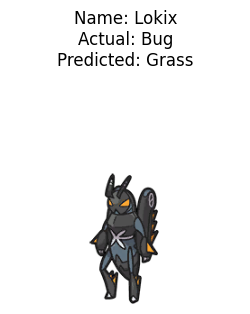


Misclassified Both Types:


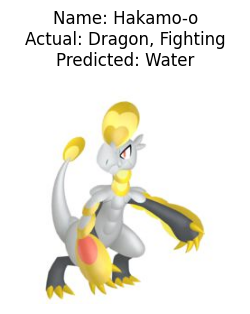

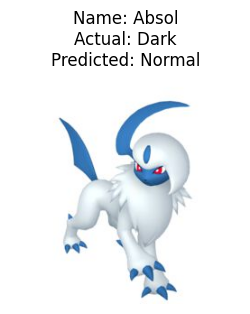

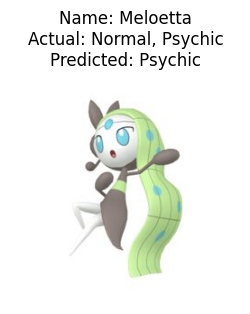

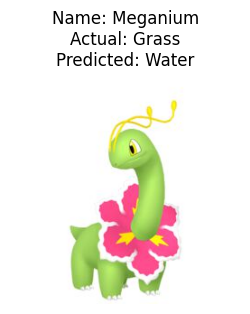

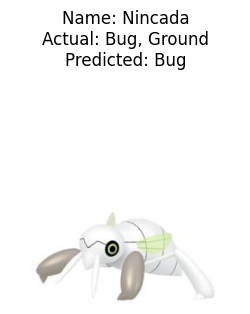

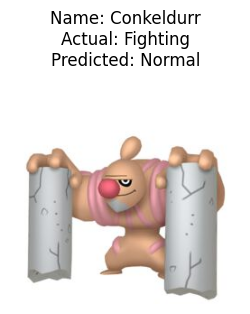

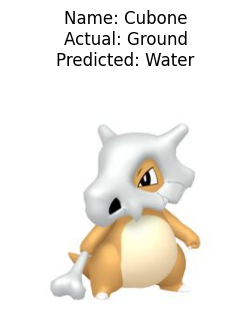

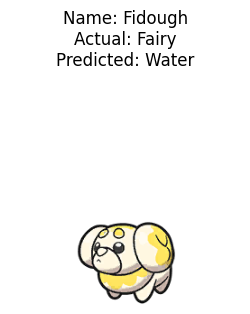

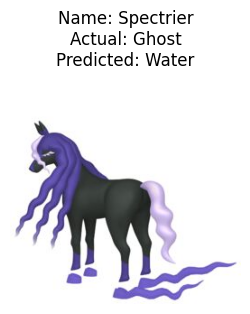

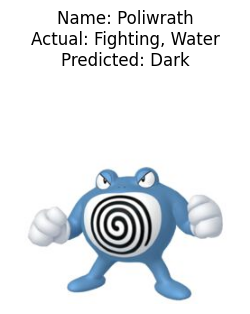


Misclassified Generations:


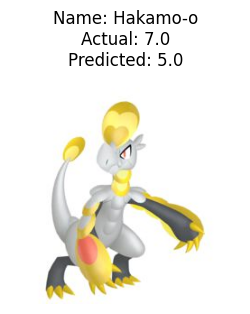

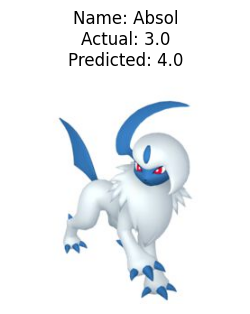

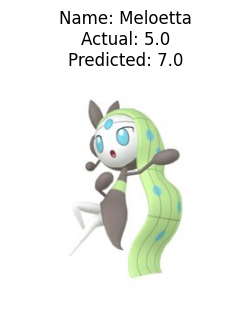

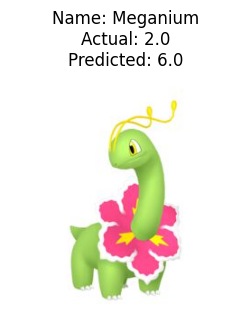

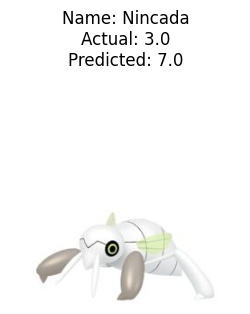

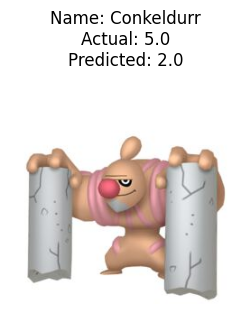

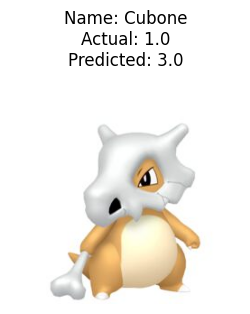

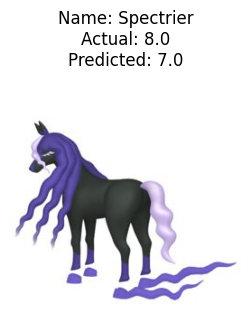

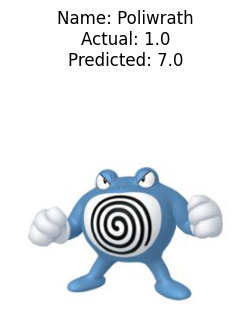

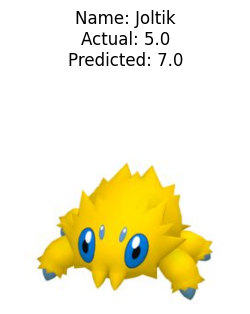

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def create_classification_df(test_names, actual_labels, predicted_labels, label_type, test_generations=None):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Create base DataFrames
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })
    
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    # Add Generation information if provided
    if test_generations is not None:
        misclassified_df['Generation'] = test_generations.iloc[misclassified_indices].values
        correct_df['Generation'] = test_generations.iloc[correct_indices].values

    return misclassified_df, correct_df

# Create DataFrames with generation information
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary",
    test_df['Generation']
)

# For both types
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Generation': test_df['Generation'].iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Generation': test_df['Generation'].iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    y_pred_generation,
    "Generation",
    test_df['Generation']
)

def display_misclassified_images(misclassified_df, column_name, num_examples=10):
    for _, row in misclassified_df.head(num_examples).iterrows():
        # Construct image path
        image_path = os.path.join('/Users/marvinchen/Desktop/IW/cos-independent-work/pokemon_test_images', 
                                f"gen_{row['Generation']}" if 'Generation' in row else '', 
                                f"{row['Name']}.png")
        
        # Open and display image
        try:
            img = Image.open(image_path)
            plt.figure(figsize=(3, 3))
            plt.imshow(img)
            
            # Format title based on column name
            if column_name == 'Types':
                plt.title(f"Name: {row['Name']}\nActual: {row['Actual Types']}\nPredicted: {row['Predicted Types']}")
            else:
                plt.title(f"Name: {row['Name']}\nActual: {row[f'Actual {column_name}']}\nPredicted: {row[f'Predicted {column_name}']}")
            
            plt.axis('off')
            plt.show()
        except FileNotFoundError:
            print(f"Image not found for {row['Name']}")

# Display misclassified examples
print("Misclassified Primary Types:")
display_misclassified_images(misclassified_primary_df, 'Primary')

print("\nMisclassified Both Types:")
display_misclassified_images(misclassified_both_df, 'Types')

print("\nMisclassified Generations:")
display_misclassified_images(misclassified_generation_df, 'Generation')

## Attempt at Hierarchal Classifcation

In [7]:
from sklearn.metrics import hamming_loss, jaccard_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define evaluation metrics
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Define type categories and threshold
type_hierarchy = {
    'physical': ['Fighting', 'Ground', 'Rock', 'Steel'],
    'special': ['Psychic', 'Ghost', 'Dark', 'Fairy'],
    'elemental': ['Fire', 'Water', 'Electric', 'Ice'],
    'natural': ['Grass', 'Bug', 'Flying', 'Dragon', 'Poison'],
    'basic': ['Normal']
}
threshold = 0.5

# Create hierarchical labels from binary labels
def create_hierarchical_labels(y_bin, type_hierarchy):
    category_labels = np.zeros((len(y_bin), len(type_hierarchy)))
    for i, (category, types) in enumerate(type_hierarchy.items()):
        type_indices = [list(mlb.classes_).index(t) for t in types if t in mlb.classes_]
        category_labels[:, i] = np.any(y_bin[:, type_indices], axis=1)
    return category_labels

# Create training and test hierarchical labels
y_train_categories = create_hierarchical_labels(y_train_both_bin, type_hierarchy)
y_test_categories = create_hierarchical_labels(y_test_both_bin, type_hierarchy)

# Train category-level model
param_grid_category = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_category = RandomForestClassifier(random_state=42)
grid_search_category = GridSearchCV(
    rf_category, param_grid_category, cv=5,
    scoring='f1_macro', n_jobs=-1
)
grid_search_category.fit(X_train_final, y_train_categories)

# Train type-level models and store probabilities
type_models = {}
y_pred_both_probas = np.zeros((len(X_test_final), len(mlb.classes_)))

for category, types in type_hierarchy.items():
    type_indices = [list(mlb.classes_).index(t) for t in types]
    category_mask = y_train_categories[:, list(type_hierarchy.keys()).index(category)] == 1
    
    if np.any(category_mask):
        rf = RandomForestClassifier(**grid_search_category.best_params_, random_state=42)
        rf.fit(X_train_final[category_mask], y_train_both_bin[category_mask][:, type_indices])
        type_models[category] = rf
        
        # Get probabilities for each type
        probs = rf.predict_proba(X_test_final)
        if isinstance(probs, list):
            for i, prob in enumerate(probs):
                y_pred_both_probas[:, type_indices[i]] = prob[:, 1]  # Take probability of class 1
        else:
            y_pred_both_probas[:, type_indices[0]] = probs[:, 1]  # Take probability of class 1

# Make predictions using threshold
y_pred_both = (y_pred_both_probas >= threshold).astype(int)

# Ensure at least one type prediction
for i in range(len(y_pred_both)):
    if not np.any(y_pred_both[i]):
        max_prob_idx = np.argmax(y_pred_both_probas[i])
        y_pred_both[i, max_prob_idx] = 1

# Calculate metrics
print("\nBoth Types Metrics:")
print(f"Exact Match Ratio: {np.mean(np.all(y_pred_both == y_test_both_bin, axis=1)):.3f}")
print(f"Jaccard Score: {jaccard_score(y_test_both_bin, y_pred_both, average='samples'):.3f}")
print(f"F1 Score: {f1_score(y_test_both_bin, y_pred_both, average='samples'):.3f}")
print(f"Hamming Loss: {hamming_loss(y_test_both_bin, y_pred_both):.3f}")
print(f"Precision@2: {precision_at_k(y_test_both_bin, y_pred_both_probas, k=2):.3f}")
print(f"Recall@2: {recall_at_k(y_test_both_bin, y_pred_both_probas, k=2):.3f}")

/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


IndexError: index 1 is out of bounds for axis 1 with size 1